# Combat Interactions Analyzer for Evesight Django Project

for EVE online (www.eveonline.com) using game log files stored on local machine

crafted by Khlaa Sor of KS Endeavours (*work in progress, improvement suggestions welcome via in-game mail*)

In [1]:
import os
import io
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") #  setting the visualization style
sns.set_context("notebook", font_scale=.9) # setting the visualization scale
import numpy as np
from PIL import Image

%matplotlib inline

In [2]:
# function to produce a list of explode values for pie charts
def pie_exploder(vals):
    """
    :vals: a list of values to be represented by the pie vedges, sorted in descending order for best results
    :return: a list of explode values for pie charts to only explode very narrow vedges
    :required: numpy
    """
    e = 0.01 # default explode value for all vedges
    explode = np.zeros(len(vals)) + e # generating default list of uniform explode values with numpy
    i = 0
    for val in vals:
        if val / sum(vals) < 0.03: #  tiny vedge qualification treshold (fraction of the total sum)
            explode[i] = e #  in the first run, default explode value is applied unchanged
            e += .09 #  incrementing the explode value starting from the second encountered tiny vedge
        i += 1

    return explode

## 1. Data selection and acquisition.

In [4]:
# Gamelogs directory path - unique for each user. CHANGE TO YOUR VALUE HERE
w_dir = r'D:\\WinDirs\\Documents\\EVE\\logs\\Gamelogs\\'
w_dir = w_dir.replace('\\', '/')

# Building the list of log files potentially suitable for analysis
log_files = []
with os.scandir(w_dir) as all_files:
    for entry in all_files:
        if entry.stat().st_size > 512: # excluding very small files
            log_files.append(entry.name)

# Sorting the list of log files from newest down
log_files.sort(reverse=True)

# Looking for certain kind of targets
entity = input('Entity to search for (any part of name, Enter to skip): ')

if entity:
    traced = [] # list to hold file names where target of interest was detected
    for entry in log_files:
        path = w_dir + entry
        with open(path, encoding='utf-8') as file:
            if entity in file.read():
                traced.append(entry)

    if traced:
        log_files = traced
        print(f'{entity} traced in the following op logs ({len(log_files)}):')
    else:
        print('No traces detected.')    
else: 
    print('Not specified')
    print(f'Acquired the following log files ({len(log_files)}):')

Entity to search for (any part of name, Enter to skip):  


Not specified
Acquired the following log files (203):


In [5]:
for entry in log_files:
    print(entry)

20230223_051134_91278319.txt
20230217_113327_91278319.txt
20230216_132155_91278319.txt
20230215_123106_91278319.txt
20230214_050438_91278319.txt
20230213_055931_91278319.txt
20230210_113007_91278319.txt
20230208_113607_91278319.txt
20230208_033922_91278319.txt
20230207_131304_91278319.txt
20230206_181735_91278319.txt
20230206_121104_91278319.txt
20230205_183317_91278319.txt
20230201_162319_91674768.txt
20230128_182957_91278319.txt
20221225_042007_91278319.txt
20221224_111557_91278319.txt
20221224_100244_91278319.txt
20221224_052346_91278319.txt
20221223_111012_91278319.txt
20221223_100443_91278319.txt
20221223_033048_91278319.txt
20221222_142927_91278319.txt
20221222_115248_91278319.txt
20221215_130318_91278319.txt
20221214_170526_91278319.txt
20221214_051119_91278319.txt
20221214_045705_91278319.txt
20221213_171746_91278319.txt
20221213_160050_91278319.txt
20221212_121100_91278319.txt
20221211_135306_91278319.txt
20221210_054812_91278319.txt
20221209_120340_91278319.txt
20221209_10284

In [53]:
# Selecting the file to analyse
file_name = input('Log file name to analyze, Enter for latest: ')
if not file_name:
    file_name = log_files[0] # defaulting to the latest file

# Constructing the log file path
file_path = w_dir + file_name
print(file_path)

Log file name to analyze, Enter for latest:  20221101_044900_91278319.txt


D://WinDirs//Documents//EVE//logs//Gamelogs//20221101_044900_91278319.txt


In [54]:
disruprive_tetrimons = '20221101_044900_91278319.txt'
ewarring_corpii = '20221116_141731_91674768.txt'

In [55]:
# reading the file and getting rid of the tags in the process
with open(file_path) as log_file:
    lines = [re.sub('<.+?>', '', #  replacing each tag with empty string
                    line.strip() 
                   ) for line in log_file.readlines()]
if lines:
    print(f'Log data loaded: {len(lines)} entries')

Log data loaded: 1631 entries


In [56]:
# printing the log out line by line
for line in lines:
    print(line)

------------------------------------------------------------
Gamelog
Listener: Khlaa Sor
Session Started: 2022.11.01 04:49:00
------------------------------------------------------------
[ 2022.11.01 04:51:16 ] (None) Undocking from Chidah VIII - Moon 17 - CONCORD Assembly Plant to Chidah solar system.
[ 2022.11.01 04:52:31 ] (None) Jumping from Chidah to Shenela
[ 2022.11.01 04:53:19 ] (None) Jumping from Shenela to Dooz
[ 2022.11.01 04:54:19 ] (notify) There are not enough charges to fully load all of your modules. Some of your modules have been left partially loaded or empty.
[ 2022.11.01 04:57:18 ] (notify) Loading the Scanner Probe into the Scan Probe Launcher; this will take approximately 10 seconds.
[ 2022.11.01 05:03:33 ] (None) Jumping from Dooz to Uzistoon
[ 2022.11.01 05:04:10 ] (notify) Requested to dock at Uzistoon VII - Moon 15 - Ammatar Fleet Assembly Plant station
[ 2022.11.01 05:04:10 ] (notify) Your docking request has been accepted. Your ship will be towed into stati

## 2. Preparing the data for analisys with Pandas.

In [57]:
lines = [line for line in lines if line.startswith('[ ')]
lines = [line.strip('[ ').replace(' ]', '', 1).replace('\xa0', '_') for line in lines]  # cleaning the timestamps and nbspaces
lines

['2022.11.01 04:51:16 (None) Undocking from Chidah VIII - Moon 17 - CONCORD Assembly Plant to Chidah solar system.',
 '2022.11.01 04:52:31 (None) Jumping from Chidah to Shenela',
 '2022.11.01 04:53:19 (None) Jumping from Shenela to Dooz',
 '2022.11.01 04:54:19 (notify) There are not enough charges to fully load all of your modules. Some of your modules have been left partially loaded or empty.',
 '2022.11.01 04:57:18 (notify) Loading the Scanner Probe into the Scan Probe Launcher; this will take approximately 10 seconds.',
 '2022.11.01 05:03:33 (None) Jumping from Dooz to Uzistoon',
 '2022.11.01 05:04:10 (notify) Requested to dock at Uzistoon VII - Moon 15 - Ammatar Fleet Assembly Plant station',
 '2022.11.01 05:04:10 (notify) Your docking request has been accepted. Your ship will be towed into station.',
 '2022.11.01 05:51:44 (None) Undocking from Uzistoon VII - Moon 15 - Ammatar Fleet Assembly Plant to Uzistoon solar system.',
 '2022.11.01 05:52:18 (None) Jumping from Uzistoon to Doo

In [58]:
# Getting a list of all combat related entries:
timestamp_length = len('2022.11.01 08:29:30')
combat = [line for line in lines if ' (combat) ' in line[:timestamp_length + len(' (combat) ') + 2]]
combat

['2022.11.01 08:28:39 (combat) Tetrimon Heretic misses you completely',
 '2022.11.01 08:28:39 (combat) Tetrimon Crucifier misses you completely',
 '2022.11.01 08:28:47 (combat) 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:47 (combat) 67 from Tetrimon Crucifier - Wrecks',
 '2022.11.01 08:28:47 (combat) Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:28:49 (combat) 65 from Tetrimon Heretic - Penetrates',
 '2022.11.01 08:28:49 (combat) 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:49 (combat) Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:28:51 (combat) 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:53 (combat) 209 from Tetrimon Heretic - Scourge Rocket - Hits',
 '2022.11.01 08:28:53 (combat) 20 from Tetrimon Crucifier - Hits',
 '2022.11.01 08:28:53 (combat) 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',


In [59]:
# also replacing '(combat)' with '-' to use as a column separator
combat = [line.replace('(combat)', '-', 1) for line in combat]
combat

['2022.11.01 08:28:39 - Tetrimon Heretic misses you completely',
 '2022.11.01 08:28:39 - Tetrimon Crucifier misses you completely',
 '2022.11.01 08:28:47 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:47 - 67 from Tetrimon Crucifier - Wrecks',
 '2022.11.01 08:28:47 - Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:28:49 - 65 from Tetrimon Heretic - Penetrates',
 '2022.11.01 08:28:49 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:49 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:28:51 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:53 - 209 from Tetrimon Heretic - Scourge Rocket - Hits',
 '2022.11.01 08:28:53 - 20 from Tetrimon Crucifier - Hits',
 '2022.11.01 08:28:53 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:55 - 53 from Tetrimon Crucifier - Scourge Light Missile - Hits',


In [60]:
# Getting a list of damage-exchange entries (by filtering misses, attempts and e-war interactions out)
hits = [
    line for line in combat if (
    line.endswith('- Grazes')) or (
    line.endswith('- Hits')) or (
    line.endswith('- Glances Off')) or (
    line.endswith('- Smashes')) or (
    line.endswith('- Penetrates')) or (
    line.endswith('- Wrecks'))
]
hits

['2022.11.01 08:28:47 - 67 from Tetrimon Crucifier - Wrecks',
 '2022.11.01 08:28:49 - 65 from Tetrimon Heretic - Penetrates',
 '2022.11.01 08:28:53 - 209 from Tetrimon Heretic - Scourge Rocket - Hits',
 '2022.11.01 08:28:53 - 20 from Tetrimon Crucifier - Hits',
 '2022.11.01 08:28:55 - 53 from Tetrimon Crucifier - Scourge Light Missile - Hits',
 '2022.11.01 08:28:55 - 749 from Tetrimon Oracle - Glances Off',
 '2022.11.01 08:28:55 - 1479 from Tetrimon Oracle - Smashes',
 '2022.11.01 08:28:58 - 209 from Tetrimon Heretic - Scourge Rocket - Hits',
 '2022.11.01 08:28:59 - 48 from Tetrimon Heretic - Glances Off',
 '2022.11.01 08:28:59 - 21 from Tetrimon Crucifier - Hits',
 '2022.11.01 08:29:02 - 112 to Tetrimon Oracle - Federation Navy Hobgoblin - Penetrates',
 '2022.11.01 08:29:02 - 109 to Tetrimon Oracle - Federation Navy Hobgoblin - Penetrates',
 '2022.11.01 08:29:02 - 66 to Tetrimon Oracle - Federation Navy Hobgoblin - Glances Off',
 '2022.11.01 08:29:02 - 71 to Tetrimon Oracle - Federati

In [61]:
# and preparing it for dataframing by turning each entry into a row of cells
# installing column separators '-' and performing the split
hits = [line.replace(' to ', ' - to - ').replace(' from ', ' - from - ').split(' - ')  for line in hits] 
# inserting 'Unknown' for missing enemy weapon data
for entry in hits:
    if len(entry) != 6:
        entry.insert(-1, 'Unknown')

# Taking only dealt damage entries
# dealt = [entry for entry in hits if 'to' in entry]
# Creating the dealt damage dataframe
columns = ['Time', 'Damage', 'Direction', 'Entity', 'Weapon', 'Token']
# dealt_df = pd.DataFrame(data=dealt, columns=columns)

# dealt_df.Damage = dealt_df.Damage.astype('int')  # Casting the damage scores to integer

# Creating the damage exchange dataframe
hits_df =pd.DataFrame(data=hits, columns=columns)
hits_df.Damage = hits_df.Damage.astype('int')  # Casting the damage scores to integer

In [62]:
hits_df.describe(include='all')

,Time,Damage,Direction,Entity,Weapon,Token
count,1060,1060.000000,1060,1060,1060,1060
unique,470,NaN,2,7,8,6
top,2022.11.01 08:37:27,NaN,to,Tetrimon Curse,Federation Navy Hammerhead,Hits
freq,9,NaN,613,236,289,468
mean,NaN,165.780189,NaN,NaN,NaN,NaN
std,NaN,240.972467,NaN,NaN,NaN,NaN
min,NaN,7.000000,NaN,NaN,NaN,NaN
25%,NaN,53.000000,NaN,NaN,NaN,NaN
50%,NaN,86.000000,NaN,NaN,NaN,NaN
75%,NaN,132.000000,NaN,NaN,NaN,NaN


In [63]:
hits_df.Token.unique()

array(['Wrecks', 'Penetrates', 'Hits', 'Glances Off', 'Smashes', 'Grazes'],
      dtype=object)

### 2a. Other than HIts

- Energy
- Warp prevention
- Misses
- Bounty

In [64]:
non_hits = [line for line in combat if (
    'misses' in line) or (
    'attempt' in line) or (
    'GJ energy' in line) or (
    "jammed by" in line)]

non_hits

['2022.11.01 08:28:39 - Tetrimon Heretic misses you completely',
 '2022.11.01 08:28:39 - Tetrimon Crucifier misses you completely',
 '2022.11.01 08:28:47 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:47 - Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:28:49 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:49 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:28:51 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:53 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:55 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:57 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:59 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:01 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimo

In [65]:
len(hits + non_hits) == len(combat)

True

In [66]:
combat

['2022.11.01 08:28:39 - Tetrimon Heretic misses you completely',
 '2022.11.01 08:28:39 - Tetrimon Crucifier misses you completely',
 '2022.11.01 08:28:47 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:47 - 67 from Tetrimon Crucifier - Wrecks',
 '2022.11.01 08:28:47 - Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:28:49 - 65 from Tetrimon Heretic - Penetrates',
 '2022.11.01 08:28:49 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:49 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:28:51 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:53 - 209 from Tetrimon Heretic - Scourge Rocket - Hits',
 '2022.11.01 08:28:53 - 20 from Tetrimon Crucifier - Hits',
 '2022.11.01 08:28:53 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:55 - 53 from Tetrimon Crucifier - Scourge Light Missile - Hits',


#### - Warp Prevention

In [67]:
warp_prevention = [line for line in combat if line.split(' - ', 1)[1]
                   .startswith('Warp ') and ' attempt from ' in line]
warp_prevention

['2022.11.01 08:28:47 - Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:28:49 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:29:28 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:29:52 - Warp disruption attempt from Tetrimon Crucifier to Federation Navy Hammerhead [KSER] Federation Navy Hammerhead',
 '2022.11.01 08:30:16 - Warp disruption attempt from Tetrimon Heretic to Federation Navy Hammerhead [KSER] Federation Navy Hammerhead',
 '2022.11.01 08:30:31 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:30:32 - Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:31:07 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:37:15 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:37:15 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:37:15 - Warp disruption attempt from Tetrimon Heretic to you!',
 '

In [68]:
warp_prevention_df = pd.DataFrame(
    data=[line.replace("from", "-").replace("to", "-").replace('attempt ', '').rstrip('!').split(' - ') for line in warp_prevention], 
    columns=['Time', 'Action', 'Issuer', 'Recipient']
)
warp_prevention_df

,Time,Action,Issuer,Recipient
0,2022.11.01 08:28:47,Warp disruption,Tetrimon Crucifier,you
1,2022.11.01 08:28:49,Warp disruption,Tetrimon Heretic,you
2,2022.11.01 08:29:28,Warp disruption,Tetrimon Heretic,you
3,2022.11.01 08:29:52,Warp disruption,Tetrimon Crucifier,Federation Navy Hammerhead [KSER] Federation N...
4,2022.11.01 08:30:16,Warp disruption,Tetrimon Heretic,Federation Navy Hammerhead [KSER] Federation N...
5,2022.11.01 08:30:31,Warp disruption,Tetrimon Heretic,you
6,2022.11.01 08:30:32,Warp disruption,Tetrimon Crucifier,you
7,2022.11.01 08:31:07,Warp disruption,Tetrimon Heretic,you
8,2022.11.01 08:37:15,Warp disruption,Tetrimon Heretic,you
9,2022.11.01 08:37:15,Warp disruption,Tetrimon Heretic,you


In [69]:
received = warp_prevention_df[warp_prevention_df.Recipient == "you"].drop(columns = "Recipient")
received

incoming_warp_prevention = {}
for action in received.Action.unique():
    print(f" - {action} from {', '.join(received[received.Action == action].Issuer.unique().tolist())}")
    incoming_warp_prevention[action] = ', '.join(received[received.Action == action].Issuer.unique().tolist())

incoming_warp_prevention

 - Warp disruption from Tetrimon Crucifier, Tetrimon Heretic, Tetrimon Curse, Tetrimon Commander


{'Warp disruption': 'Tetrimon Crucifier, Tetrimon Heretic, Tetrimon Curse, Tetrimon Commander'}

In [70]:
help(incoming_warp_prevention.items)

Help on built-in function items:

items(...) method of builtins.dict instance
    D.items() -> a set-like object providing a view on D's items



In [71]:
for item in incoming_warp_prevention.items():
    print(item)

('Warp disruption', 'Tetrimon Crucifier, Tetrimon Heretic, Tetrimon Curse, Tetrimon Commander')


#### - Energy War

- TO BE EXTENDED to cover all kinds of e-war interactions

In [72]:
combat

['2022.11.01 08:28:39 - Tetrimon Heretic misses you completely',
 '2022.11.01 08:28:39 - Tetrimon Crucifier misses you completely',
 '2022.11.01 08:28:47 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:47 - 67 from Tetrimon Crucifier - Wrecks',
 '2022.11.01 08:28:47 - Warp disruption attempt from Tetrimon Crucifier to you!',
 '2022.11.01 08:28:49 - 65 from Tetrimon Heretic - Penetrates',
 '2022.11.01 08:28:49 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:49 - Warp disruption attempt from Tetrimon Heretic to you!',
 '2022.11.01 08:28:51 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:53 - 209 from Tetrimon Heretic - Scourge Rocket - Hits',
 '2022.11.01 08:28:53 - 20 from Tetrimon Crucifier - Hits',
 '2022.11.01 08:28:53 - 2 GJ energy neutralized Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:55 - 53 from Tetrimon Crucifier - Scourge Light Missile - Hits',


In [73]:
neut = [line.replace('GJ energy neutralized', '-', 1) for line in combat if ' GJ energy neutralized ' in line[:timestamp_length + len(' GJ energy neutralized ') + 5]]
neut

['2022.11.01 08:28:47 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:49 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:51 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:53 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:55 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:57 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:28:59 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:01 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:03 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:05 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:07 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:09 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:12 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:14 - 2 - Tetrimon Crucifier - Tetrimon Crucifier',
 '2022.11.01 08:29:1

In [74]:
neuters = {}
for line in neut:
    sliced = line.split(' - ')
    candidate = sliced[-1]
    if sliced[-2] == candidate:
        if candidate not in neuters.keys():
            neuters[candidate] = []
        neuters[candidate].append(int(sliced[1]))
        
neuters

{'Tetrimon Crucifier': [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  2,
  2,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  2,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,
  2,
  3,
  3,
  3,
  3,
  4,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  2,
  3,
  3,
  3

In [75]:
for entity in neuters.keys():
    neuters[entity] = max(neuters[entity])
    
neuters

{'Tetrimon Crucifier': 4, 'Tetrimon Curse': 83}

In [76]:
neuters_columns = ['Time', 'GJ', 'Entity']
neuters_rows = []
neuted_columns = ['Time', 'GJ', 'Entity', 'Weapon']
neuted_rows = []


for line in neut:
    sliced = line.split(' - ')
    candidate = sliced[-1]
    if sliced[-2] == candidate:
        neuters_rows.append(sliced[:3])
    else:
        neuted_rows.append(sliced)

In [77]:
neuters_df = pd.DataFrame(data = neuters_rows, columns = neuters_columns)
neuters_df

,Time,GJ,Entity
0,2022.11.01 08:28:47,2,Tetrimon Crucifier
1,2022.11.01 08:28:49,2,Tetrimon Crucifier
2,2022.11.01 08:28:51,2,Tetrimon Crucifier
3,2022.11.01 08:28:53,2,Tetrimon Crucifier
4,2022.11.01 08:28:55,2,Tetrimon Crucifier
...,...,...,...
259,2022.11.01 08:51:11,3,Tetrimon Crucifier
260,2022.11.01 08:51:37,83,Tetrimon Curse
261,2022.11.01 08:51:49,83,Tetrimon Curse
262,2022.11.01 08:52:01,83,Tetrimon Curse


In [78]:
for entity in neuters_df.Entity.unique().tolist():
    print(entity)

Tetrimon Crucifier
Tetrimon Curse


In [79]:
neuters_df.groupby('Entity').GJ.max()

Entity
Tetrimon Crucifier     4
Tetrimon Curse        83
Name: GJ, dtype: object

In [80]:
neuted_df = pd.DataFrame(columns = neuted_columns, data = neuted_rows)
neuted_df

,Time,GJ,Entity,Weapon


In [81]:

# ewar = [line.replace('GJ energy', '-').split(' - ') for line in non_hits if "energy" in line and "from" not in line]
# for entry in ewar:
#     pack = entry.pop(2).split(' ', 1)
#     entry.insert(2, pack[0])
#     entry.insert(3, pack[1])
#     # print(entry[:-1])
    
# ewar_df = pd.DataFrame(
#     data = [entry[:-1] for entry in ewar], 
#     columns = ["Time", "GJ", "Action", "Entity"]
# )
# ewar_df

# for action in ewar_df.Action.unique():
#     print(f" - {action} by {', '.join(ewar_df[ewar_df.Action == action].Entity.unique().tolist())}")

In [82]:
# len(hits) + len(warp_prevention) + len(ewar) == len(combat)  # there are also misses!

### Bounty

In [83]:
bounty = [line.replace('\xa0', '_') for line in lines if " (bounty) " in line[:timestamp_length + len(' (bounty) ') + 2] and " ISK added to next bounty payout" in line]
bounty

[]

In [84]:
bounty = sum([int(line.split(' (bounty) ', 1)[1].split(' ')[0]) for line in bounty])

In [85]:
bounty

0

## 3. Analysing the data and displaying results

### 3.1. Summary Stats

In [86]:
# Dealt damage
dealt_df = hits_df.loc[hits_df.Direction == 'to']
targets = dealt_df.Entity.unique().tolist() 
print(f'Damage dealt to {len(targets)} kinds of targets:')
for target in targets:
    print(f' - {target}')
print()
weapons = dealt_df.Weapon.unique().tolist()
print(f'with {len(weapons)} types of weapon systems:')
for weapon in weapons:
    print(f' - {weapon}')
print()

# Incoming damage
incoming_df = hits_df.loc[hits_df.Direction == 'from']
enemies = incoming_df.Entity.unique().tolist() 
print(f'Damage taken from {len(enemies)} kinds of enemies:')
for enemy in enemies:
        print(f' - {enemy}')
print()
enemy_weapons = incoming_df.Weapon.unique().tolist()
print(f'with {len(enemy_weapons)} types of weapon systems:')
for enemy_weapon in enemy_weapons:
    print(f' - {enemy_weapon}')
print()

print("Enemy warp prevention acts:")
if not len(received):
    print("None")
for action in received.Action.unique():
    print(f" - {action} from {', '.join(received[received.Action == action].Issuer.unique().tolist())}")

print()    
# print("Enemy energy war acts:")
# if not len(ewar_df):
#     print("None")
# for action in ewar_df.Action.unique():
#     print(f" - {action} by {', '.join(ewar_df[ewar_df.Action == action].Entity.unique().tolist())}")
    
print()

Damage dealt to 7 kinds of targets:
 - Tetrimon Oracle
 - Tetrimon Crucifier
 - Tetrimon Heretic
 - Tetrimon Curse
 - Tetrimon Crusader
 - Tetrimon Augoror
 - Tetrimon Commander

with 4 types of weapon systems:
 - Federation Navy Hobgoblin
 - Inferno Fury Heavy Missile
 - Federation Navy Hammerhead
 - Inferno Heavy Missile

Damage taken from 7 kinds of enemies:
 - Tetrimon Crucifier
 - Tetrimon Heretic
 - Tetrimon Oracle
 - Tetrimon Curse
 - Tetrimon Crusader
 - Tetrimon Augoror
 - Tetrimon Commander

with 4 types of weapon systems:
 - Unknown
 - Scourge Rocket
 - Scourge Light Missile
 - Scourge Heavy Missile

Enemy warp prevention acts:
 - Warp disruption from Tetrimon Crucifier, Tetrimon Heretic, Tetrimon Curse, Tetrimon Commander




#### 3.1.1. Dealt Damage

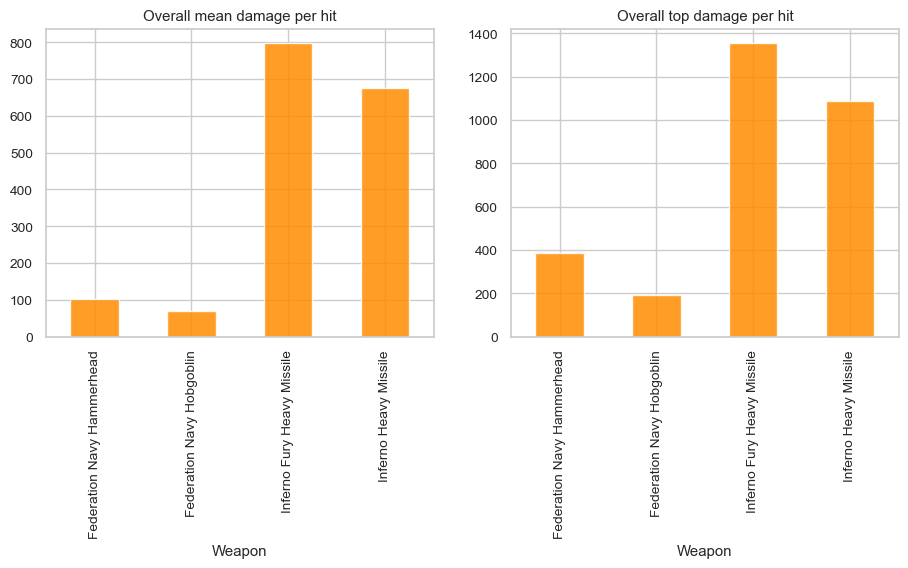

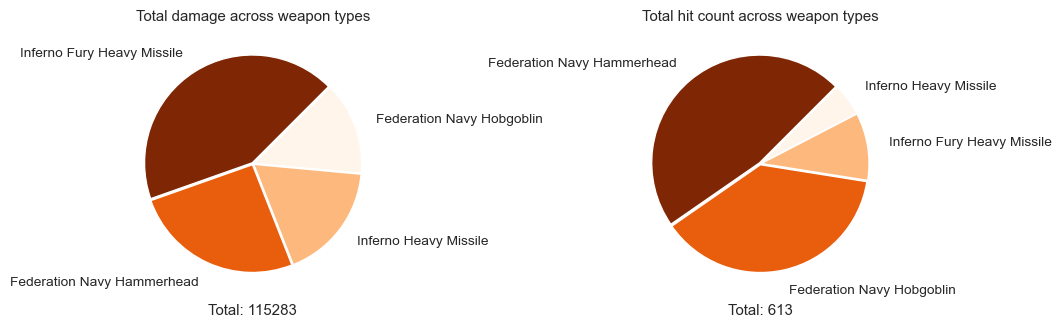

In [87]:
if weapons:
    # data for plotting
    means_per_weapon = dealt_df.groupby(['Weapon']).Damage.mean()#.sort_values(ascending=False)
    tops_per_weapon = dealt_df.groupby(['Weapon']).Damage.max()#.sort_values(ascending=False)
    totals_per_weapon = dealt_df.groupby(['Weapon']).Damage.sum().sort_values(ascending=False)
    hits_per_weapon = dealt_df.Weapon.value_counts()

    #  barcharts of mean and top damage scores per weapon
    plt.figure(figsize=(11,4)) 

    plt.subplot(121)
    means_per_weapon.plot(
        kind='bar', ylabel='', title='Overall mean damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.subplot(122)
    tops_per_weapon.plot(
        kind='bar', ylabel='', title='Overall top damage per hit', 
        color='darkorange', alpha=.85
    )

    plt.show()

    # piecharts of total damage and hit counts per weapon
    plt.figure(figsize=(12,3.5), facecolor='white') 
    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_weapon)}') #  plotting total damage per weapon
    totals_per_weapon.plot(
        kind='pie', title='Total damage across weapon types', ylabel='',
        # radius=1.1,
        labeldistance=1.2,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(totals_per_weapon)
    )
    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_weapon)}') #  plotting total number of hits per weapon
    hits_per_weapon.plot(
        kind='pie', title='Total hit count across weapon types', ylabel='',
        # radius=.9,
        labeldistance=1.2,
        cmap='Oranges_r',
        startangle = 45,
        explode = pie_exploder(hits_per_weapon)
    )
    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

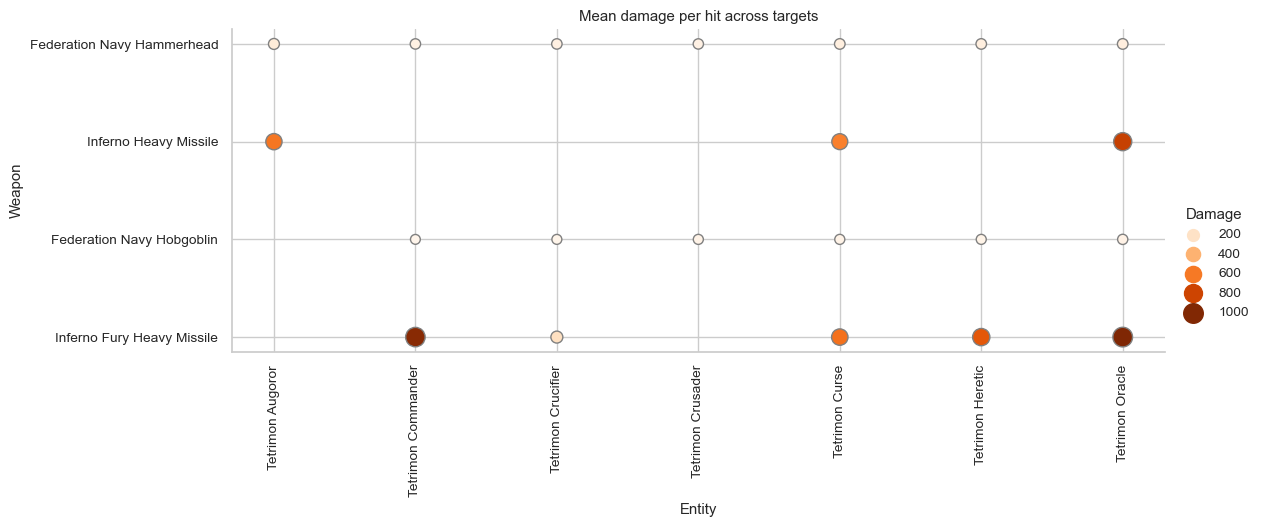

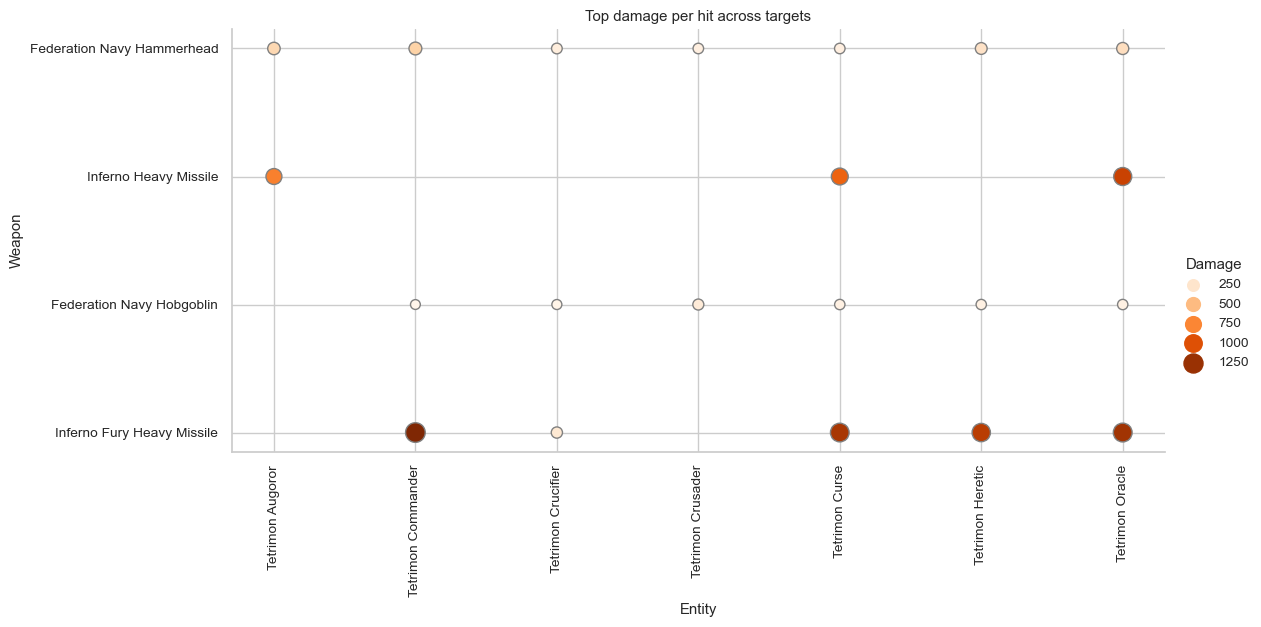

In [88]:
if weapons:
    # Plotting mean and top damage scores per weapon across all targets
    mean_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.mean()).sort_values(by='Entity').astype('int')
    top_damage_scores = pd.DataFrame(dealt_df.groupby(['Weapon', 'Entity']).Damage.max()).sort_values(by='Entity')

    # Mean damage
    x = sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, linewidth=1, edgecolor='gray',
                palette='Oranges', sizes=(50, 200)
        )
    x.ax.tick_params(axis='x', rotation=90)
    plt.title('Mean damage per hit across targets')
    x.savefig('fig.png')
    buf = io.BytesIO()
    x.savefig(buf, format='png')
    buf.seek(0)
    im = Image.open(buf)
    plt.show()


    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=5, aspect=2.4, linewidth=1, edgecolor='gray',
                palette='Oranges', sizes=(50, 200)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top damage per hit across targets')
    plt.show()

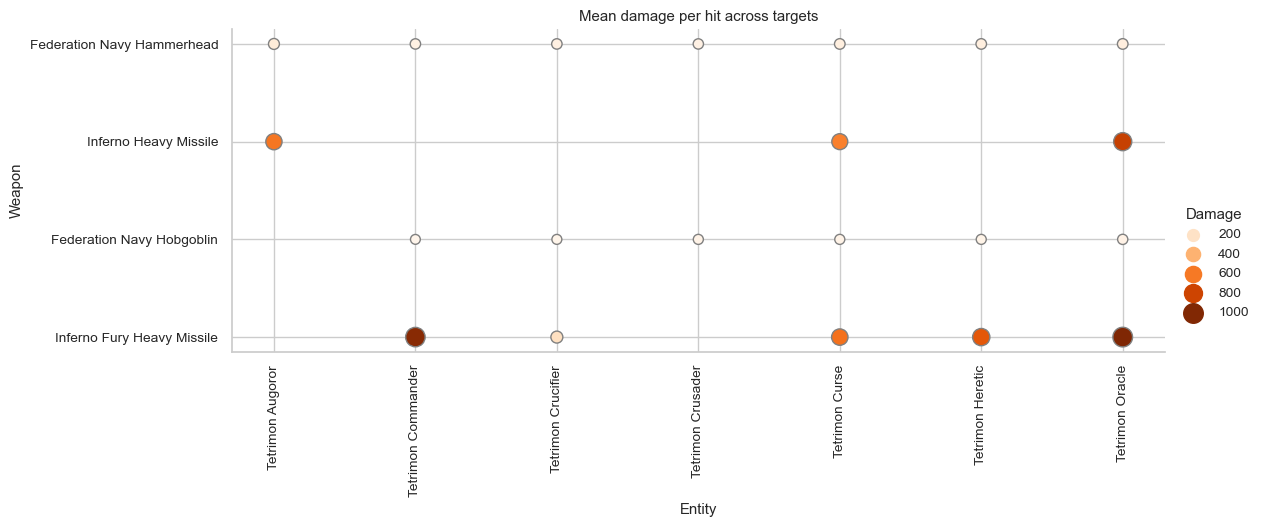

In [89]:
im

Hit quality distributions per weapon


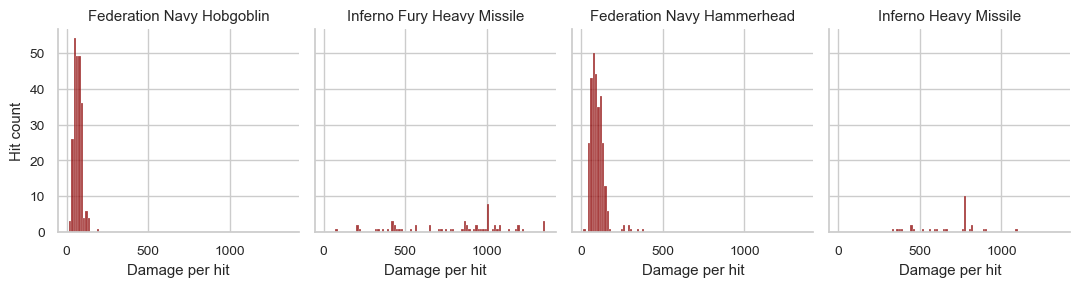

In [90]:
# Generating hit quality histograms with Seaborn
if weapons:
    print('Hit quality distributions per weapon')
    g = sns.displot(
        data=dealt_df, x="Damage", col="Weapon",
        col_wrap=5,
        height=3, aspect=.9, color='darkred'
    )
    g.set_axis_labels("Damage per hit", "Hit count")
    g.set_titles("{col_name}")
    plt.show()

**Alfa strike per weapon per target (top and bottom if much data):**

In [91]:
if weapons:
    if len(top_damage_scores) > 14:
        print(top_damage_scores.sort_values(by='Damage', ascending=False).head(7), end='\n'*2)
        print(top_damage_scores.sort_values(by='Damage', ascending=False).tail(7), end='\n'*2)
    else:
        print(top_damage_scores.sort_values(by='Damage', ascending=False), end='\n'*2)

                                               Damage
Weapon                     Entity                    
Inferno Fury Heavy Missile Tetrimon Commander    1355
                           Tetrimon Oracle       1214
                           Tetrimon Curse        1190
                           Tetrimon Heretic      1133
Inferno Heavy Missile      Tetrimon Oracle       1086
                           Tetrimon Curse         908
                           Tetrimon Augoror       775

                                               Damage
Weapon                     Entity                    
Federation Navy Hammerhead Tetrimon Crusader      148
                           Tetrimon Curse         147
Federation Navy Hobgoblin  Tetrimon Curse         132
                           Tetrimon Heretic       130
                           Tetrimon Oracle        130
                           Tetrimon Crucifier     101
                           Tetrimon Commander      85



#### 3.1.2. Incoming Damage

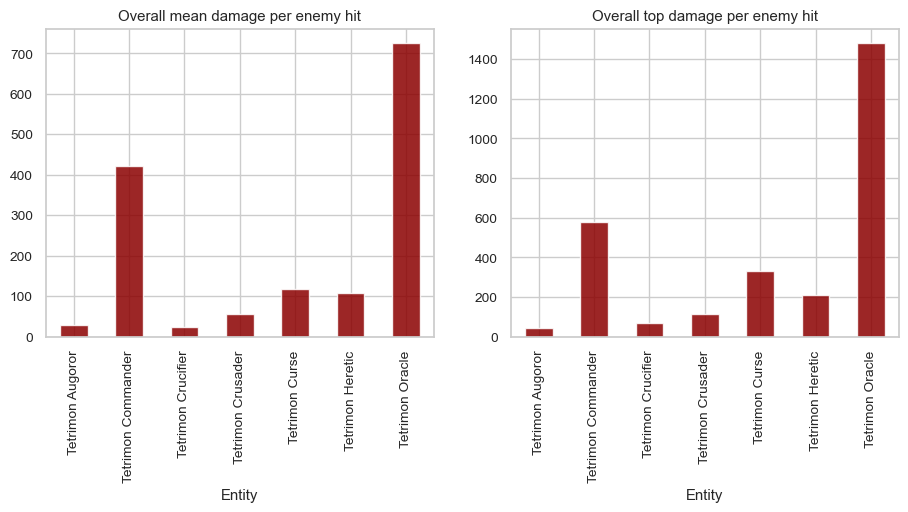

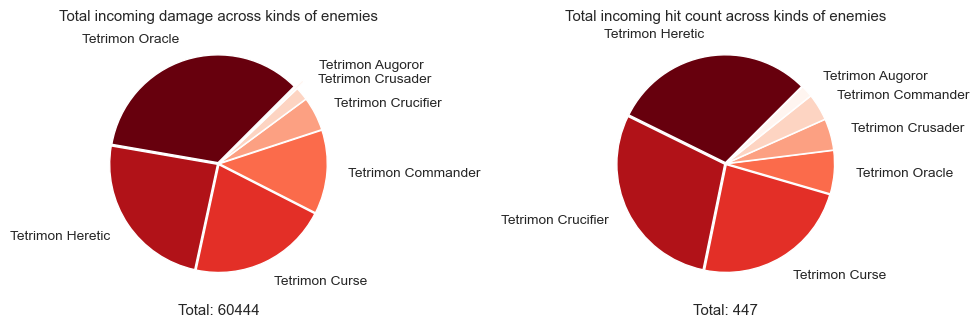

In [92]:
if enemies:
    # Data for plotting
    means_per_enemy = incoming_df.groupby(['Entity']).Damage.mean()
    tops_per_enemy = incoming_df.groupby(['Entity']).Damage.max()
    totals_per_enemy = incoming_df.groupby(['Entity']).Damage.sum().sort_values(ascending=False)
    hits_per_enemy = incoming_df.Entity.value_counts()
    
    #  barcharts of mean and top damage taken from each enemy
    plt.figure(figsize=(11,4)) 
    plt.subplot(121)
    means_per_enemy.plot(
        kind='bar', ylabel='', title='Overall mean damage per enemy hit', 
        color='darkred', alpha=.85
    )
    plt.subplot(122)
    tops_per_enemy.plot(
        kind='bar', ylabel='', title='Overall top damage per enemy hit', 
        color='darkred', alpha=.85
    )
    plt.show()
    
    # piecharts of total damage and hit counts from each enemy
    height = 3.5  # overall for the figure
    radius = 1  # for each pie
    if len(enemies) > 11: #  to provide more space for labels
        height = 5
        radius = .7
    
    plt.figure(figsize=(12,height), facecolor='white') 
    plt.subplot(121,
               xlabel=f'Total: {sum(totals_per_enemy)}')  # plotting total damage per enemy
    totals_per_enemy.plot(
        kind='pie', title='Total incoming damage across kinds of enemies', ylabel='',
        radius=radius,
        labeldistance=1.2,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(totals_per_enemy)
    )
    plt.subplot(122,
                xlabel=f'Total: {sum(hits_per_enemy)}') #  plotting total number of hits per enemy
    hits_per_enemy.plot(
        kind='pie', title='Total incoming hit count across kinds of enemies', ylabel='',
        radius=radius,
        labeldistance=1.2,
        cmap='Reds_r',
        startangle = 45,
        explode = pie_exploder(hits_per_enemy)
    )
    plt.show()
    
else:
    print('No meaningful interactions to analyze.')

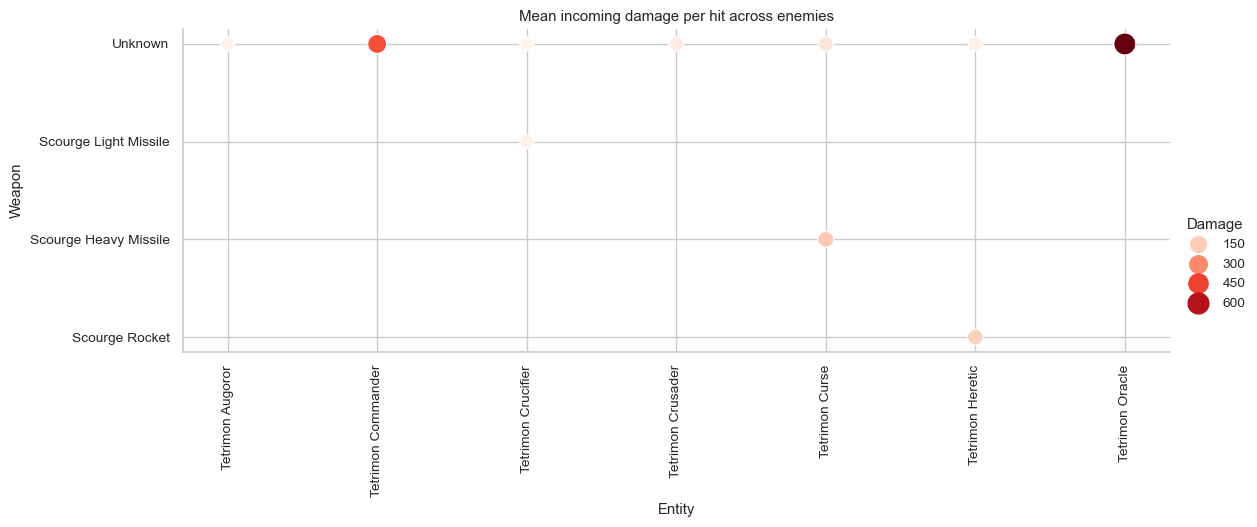

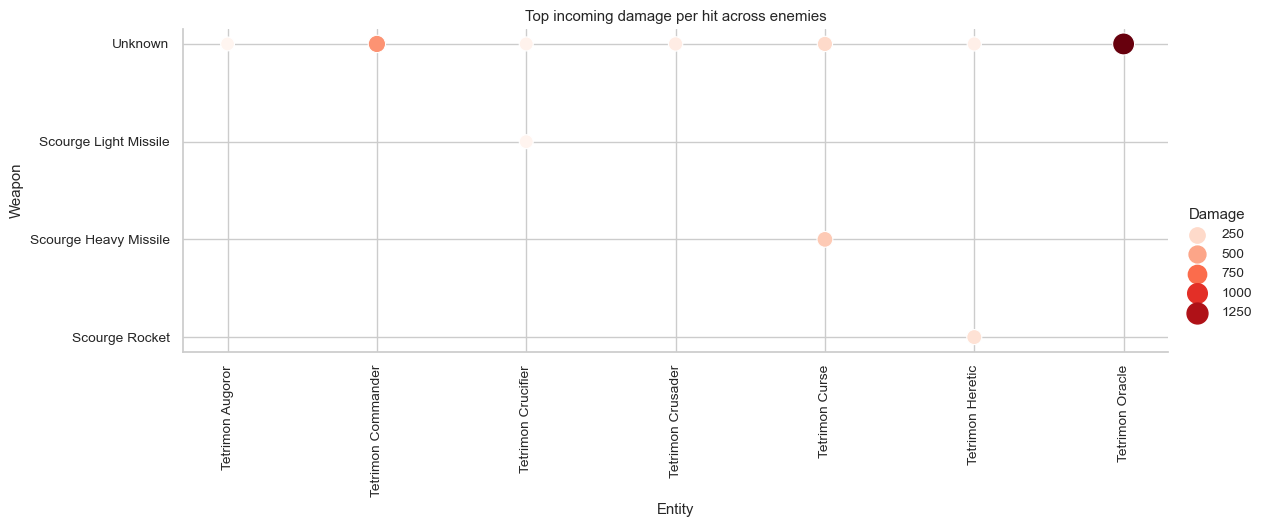

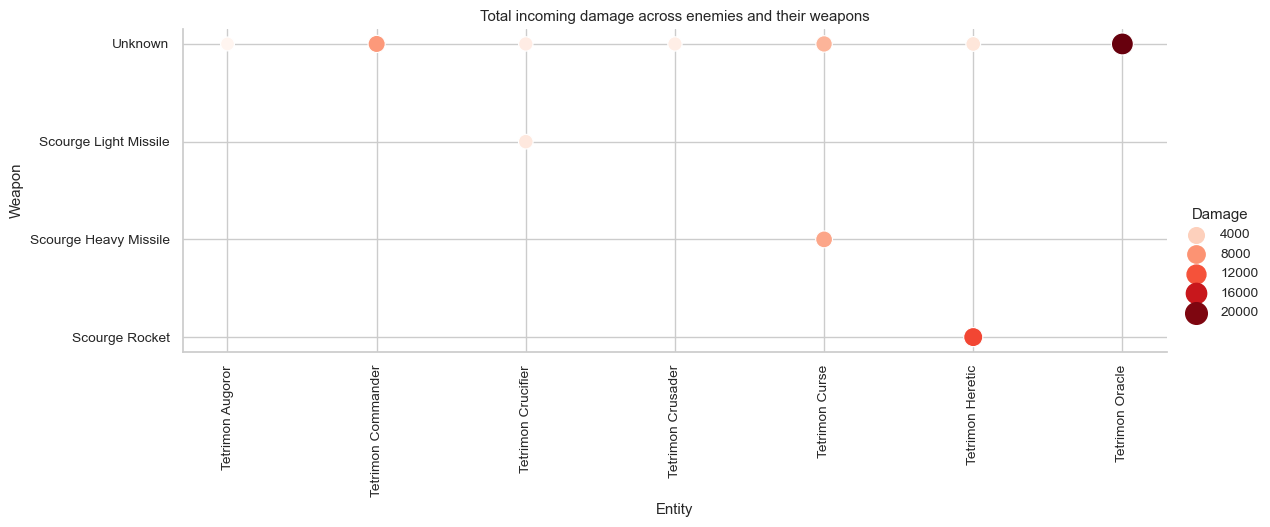

In [93]:
if len(enemy_weapons) > 1:
    # Plotting mean and top incoming damage scores per enemy weapon across all kinds of enemies
    mean_damage_scores = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.mean()).sort_values(by='Entity').astype(int)
    top_damage_scores = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.max()).sort_values(by='Entity')
    totals = pd.DataFrame(incoming_df.groupby(['Weapon', 'Entity']).Damage.sum()).sort_values(by='Entity')

    # Mean damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=mean_damage_scores, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Mean incoming damage per hit across enemies')
    plt.show()

    # Top damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=top_damage_scores, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Top incoming damage per hit across enemies')
    plt.show()
    
    # Total damage
    sns.relplot(y="Weapon", x="Entity", hue="Damage", size='Damage',
                data=totals, 
                height=4, aspect=3, 
                palette='Reds', sizes=(100, 250)
        )
    plt.tick_params(axis='x', rotation=90)
    plt.title('Total incoming damage across enemies and their weapons')
    plt.show()    

**Enemy alfa strike per weapon per kind of enemy (top 11):**

In [94]:
if enemy_weapons:
    print(top_damage_scores.sort_values(by='Damage', ascending=False).head(11), end='\n'*2)

                                          Damage
Weapon                Entity                    
Unknown               Tetrimon Oracle       1479
                      Tetrimon Commander     579
Scourge Heavy Missile Tetrimon Curse         331
Unknown               Tetrimon Curse         250
Scourge Rocket        Tetrimon Heretic       209
Unknown               Tetrimon Crusader      116
                      Tetrimon Heretic        93
                      Tetrimon Crucifier      67
Scourge Light Missile Tetrimon Crucifier      53
Unknown               Tetrimon Augoror        42



### 3.2. Weapons performance on each target


Performance on Tetrimon Oracle:



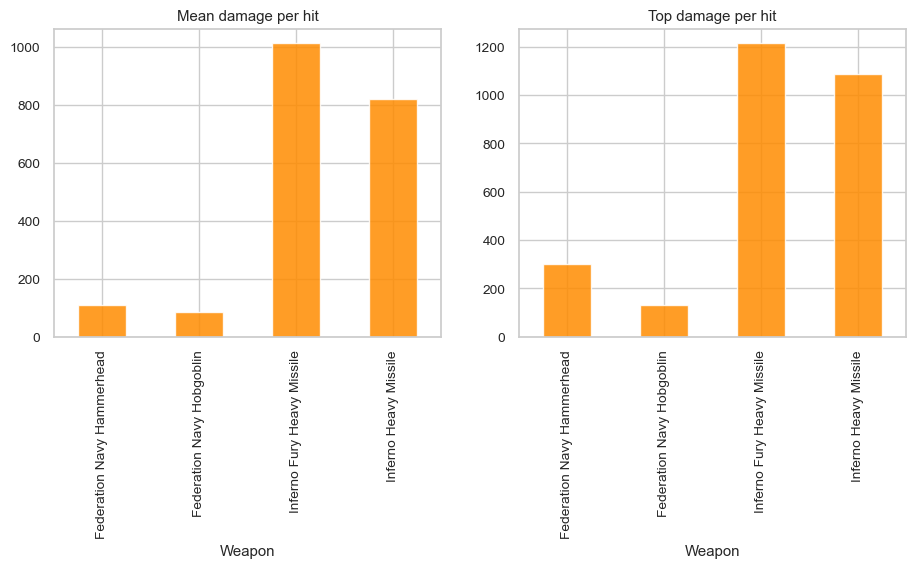

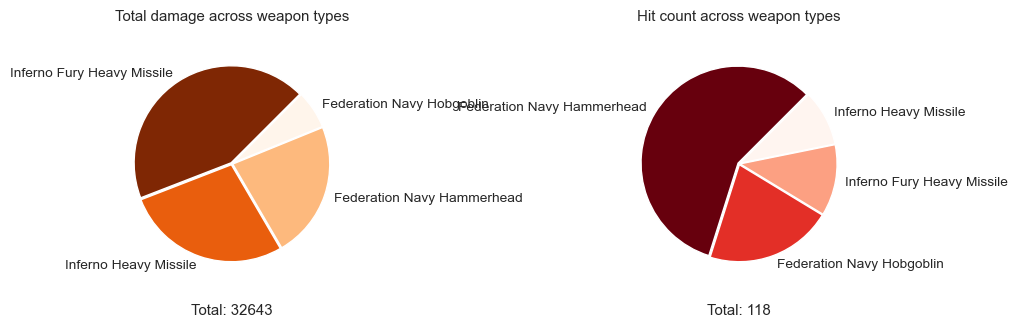

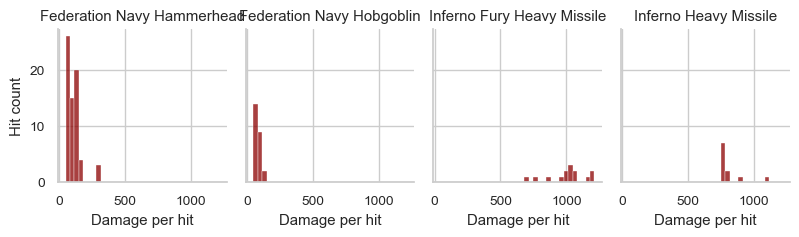



Performance on Tetrimon Crucifier:



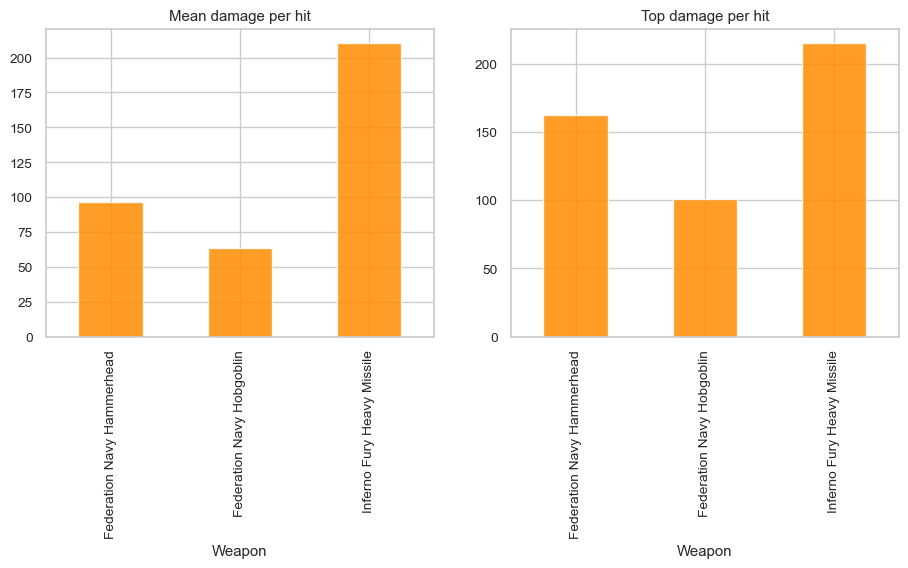

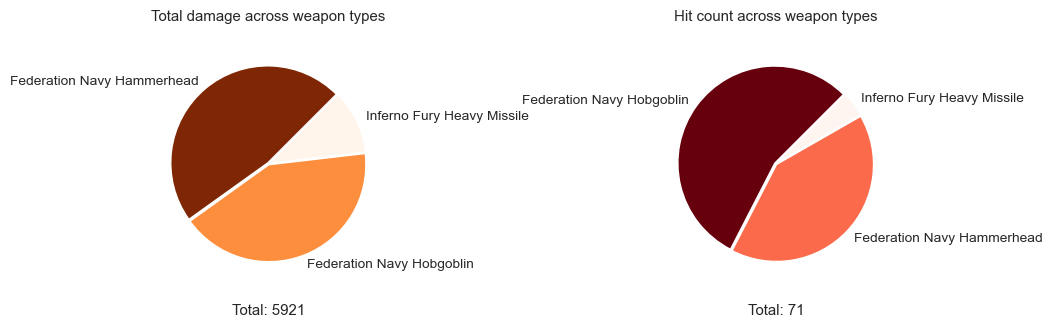

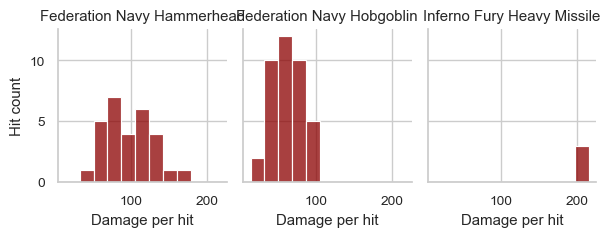



Performance on Tetrimon Heretic:



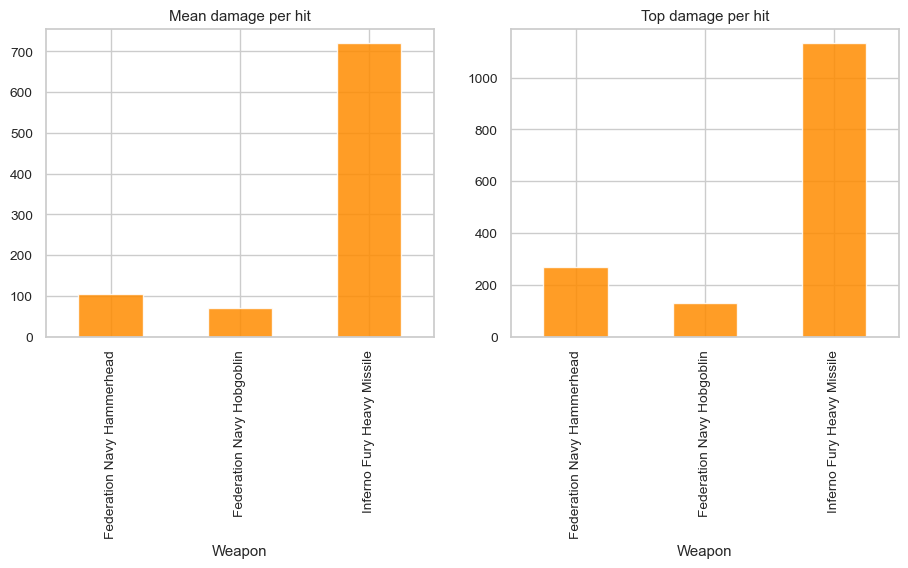

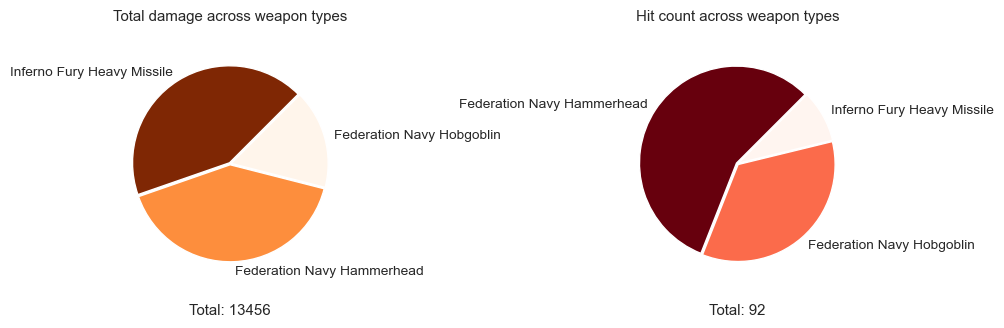

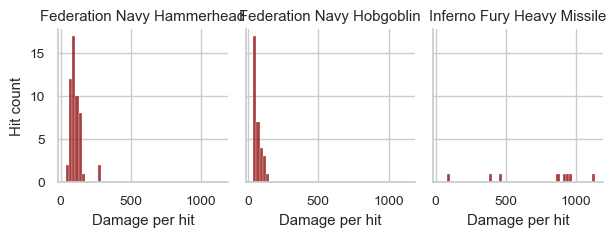



Performance on Tetrimon Curse:



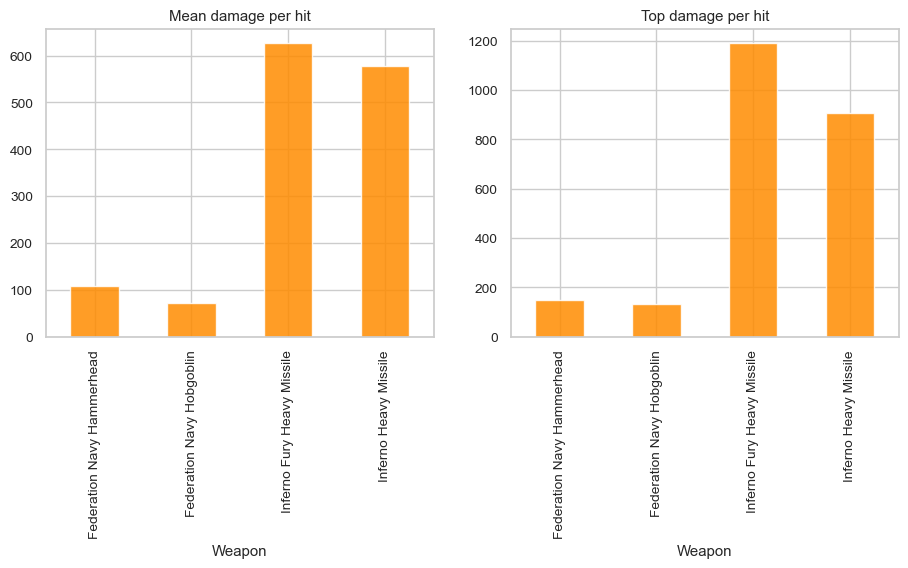

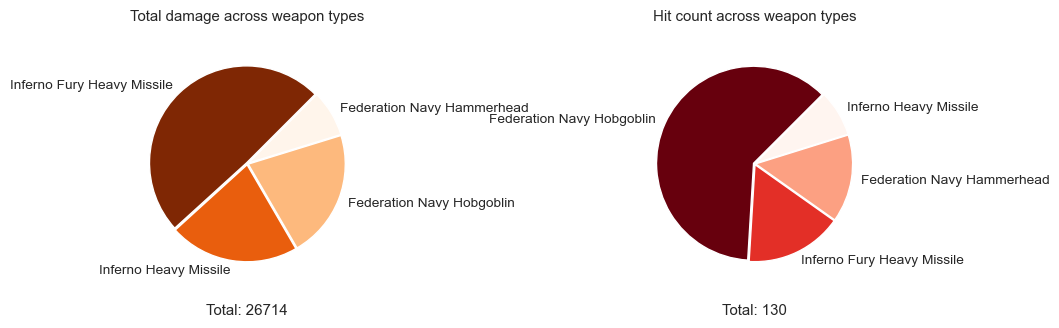

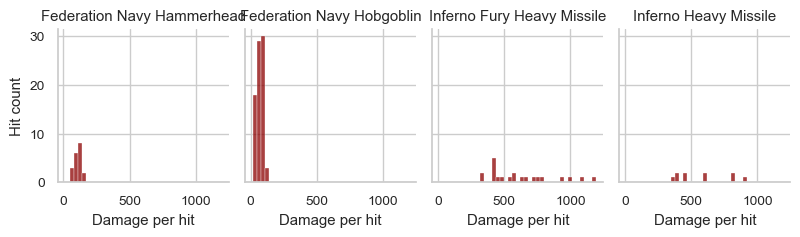



Performance on Tetrimon Crusader:



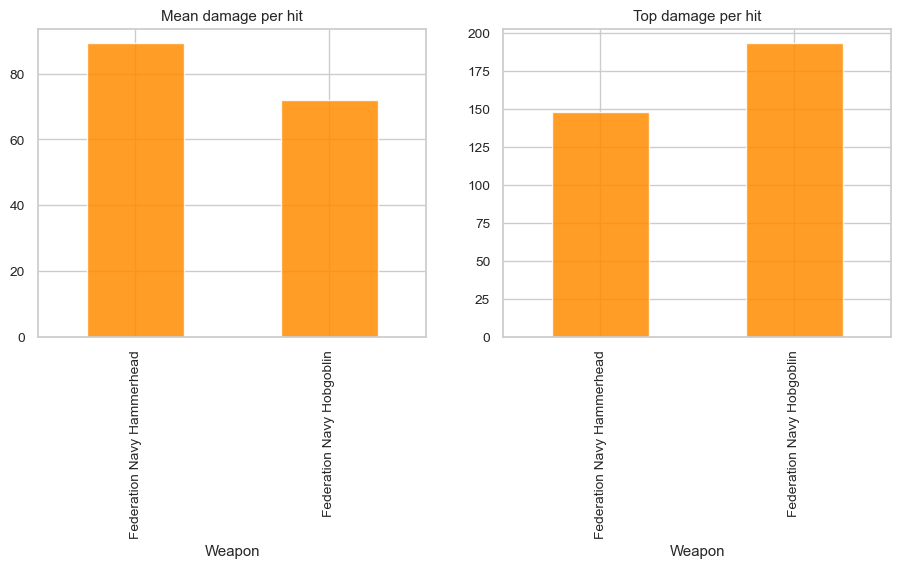

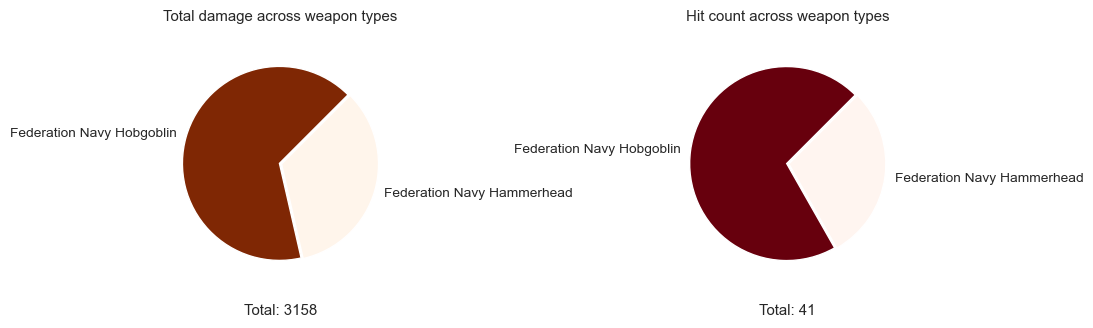

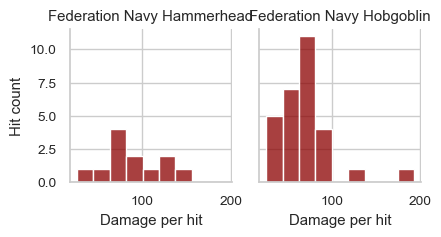



Performance on Tetrimon Augoror:



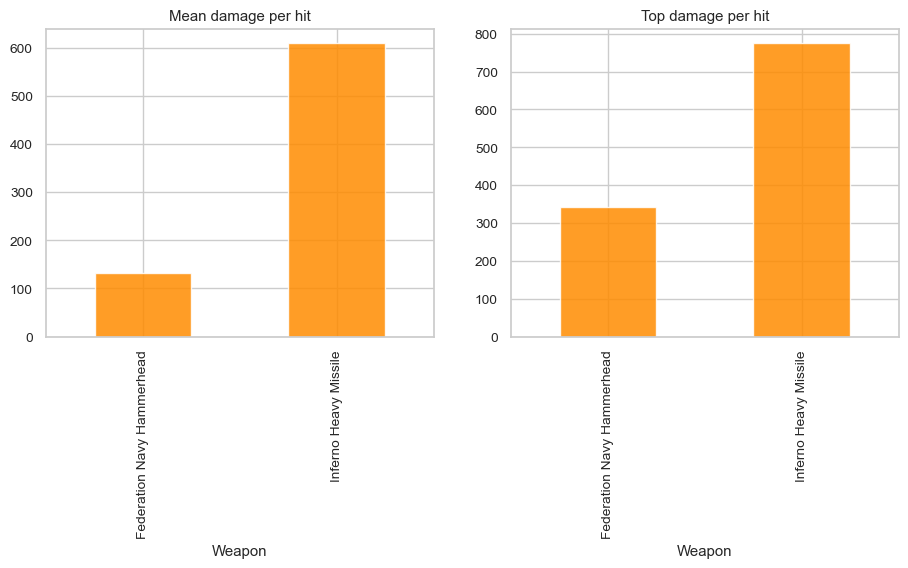

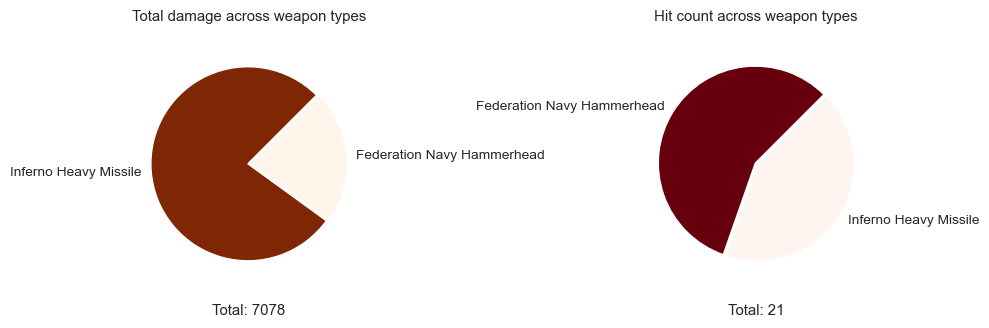

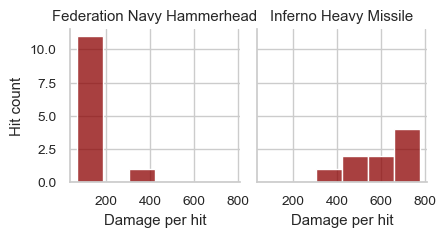



Performance on Tetrimon Commander:



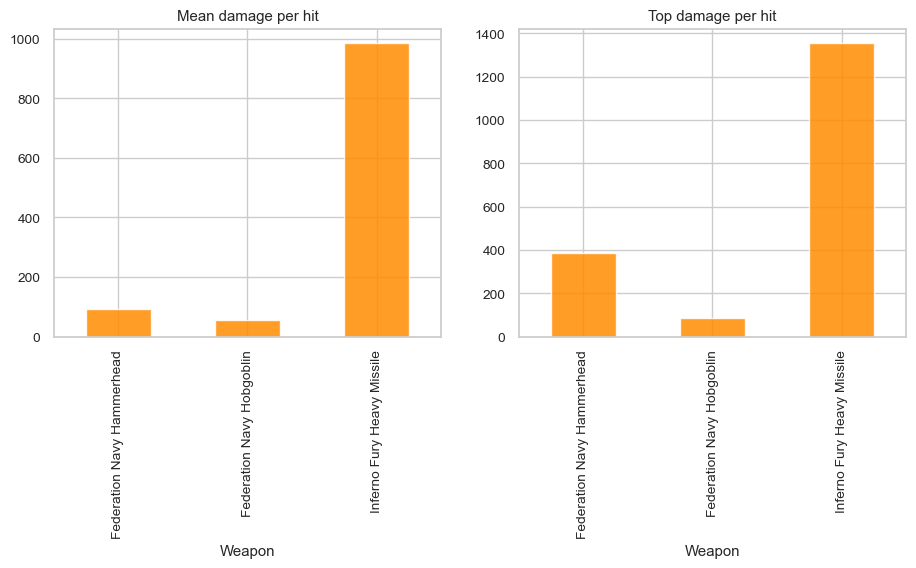

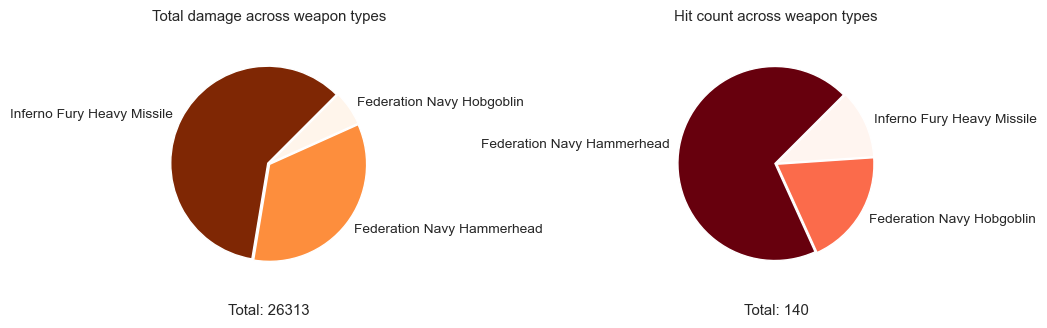

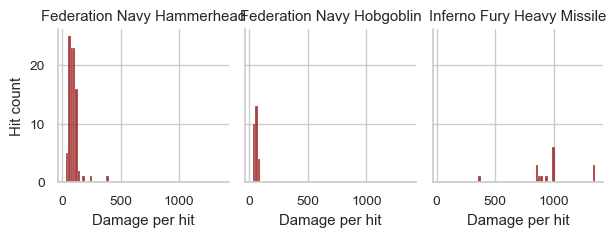

In [95]:
for target in targets:
    print(f'\nPerformance on {target}:', end='\n'*2)
    
    data_slice = dealt_df[dealt_df.Entity == target].sort_values(by='Weapon')
    
    if sum(totals_per_weapon) > 0:
        
        # mean and top damage barcharts
        plt.figure(figsize=(11,4)) 
        
        plt.subplot(121) #  plotting mean damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.mean().plot(
            kind='bar', title='Mean damage per hit',
            ylabel='', 
            color='darkorange', alpha=.85
        )
        plt.subplot(122) #  plotting top damage per hit per weapon 
        data_slice.groupby('Weapon').Damage.max().plot(
            kind='bar', title='Top damage per hit', ylabel='', 
            color='darkorange', alpha=.85
        )      
        
        plt.show()
        
        # total damage and hit count pies
        totals_per_weapon = data_slice.groupby('Weapon').Damage.sum().sort_values(ascending=False)
        hits_per_weapon = data_slice.Weapon.value_counts().sort_values(ascending=False)
        
        plt.figure(figsize=(12,3.5), facecolor='white') 

        plt.subplot(121, #  plotting total damage across weapon types
                    xlabel=f'Total: {sum(totals_per_weapon)}')
        totals_per_weapon.plot(
            kind='pie', title='Total damage across weapon types',
            radius=.9,
            # center=(0,-5),
            cmap='Oranges_r',
            ylabel='', 
            startangle = 45,
            explode = pie_exploder(totals_per_weapon)
        )
        plt.subplot(122, #  plotting hit counts per weapon
                    xlabel=f'Total: {sum(hits_per_weapon)}') 
        hits_per_weapon.plot(
            kind='pie', title='Hit count across weapon types', ylabel='',
            cmap='Reds_r',
            radius=.9,
            startangle = 45,
            explode = pie_exploder(hits_per_weapon)
        )        
        
        plt.show()
        
        # damage per hit distributions across weapon systems
        g = sns.displot(
            data=data_slice, x="Damage", col="Weapon",
            col_wrap=5,
            height=2.5, aspect=.8, color='darkred'
        )
        g.set_axis_labels("Damage per hit", "Hit count")
        g.set_titles("{col_name}")
        plt.show()
        
        print()

    else:
        print('- Zero damage scored', end='\n'*2)
        continue

In [96]:
help(Exception)

Help on class Exception in module builtins:

class Exception(BaseException)
 |  Common base class for all non-exit exceptions.
 |  
 |  Method resolution order:
 |      Exception
 |      BaseException
 |      object
 |  
 |  Built-in subclasses:
 |      ArithmeticError
 |      AssertionError
 |      AttributeError
 |      BufferError
 |      ... and 15 other subclasses
 |  
 |  Methods defined here:
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from BaseException:
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __getattribute__(self, name, /

In [97]:
import sys

In [98]:
help(sys.exc_info)

Help on built-in function exc_info in module sys:

exc_info()
    Return current exception information: (type, value, traceback).
    
    Return information about the most recent exception caught by an except
    clause in the current stack frame or in an older stack frame.



In [99]:
try:
    print(zzz)
except:
    print(help(sys.exc_info()[2]))

Help on traceback object:

class traceback(object)
 |  TracebackType(tb_next, tb_frame, tb_lasti, tb_lineno)
 |  --
 |  
 |  Create a new traceback object.
 |  
 |  Methods defined here:
 |  
 |  __dir__(...)
 |      Default dir() implementation.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  tb_frame
 |  
 |  tb_lasti
 |  
 |  tb_lineno
 |  
 |  tb_next

None
